In [1]:
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2021-07-07 01:25:22.883306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-07 01:25:22.883390: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

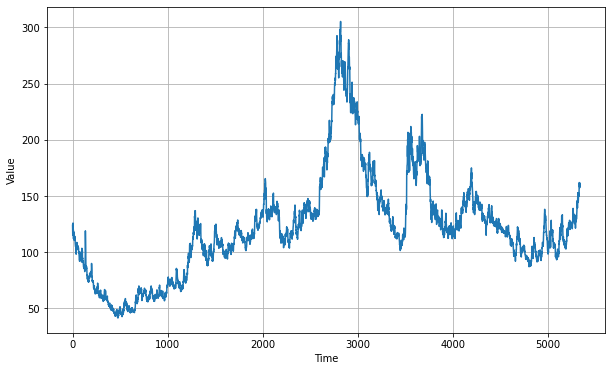

In [3]:
coffee_time_step = []
coffee_temps = []

with open('dataset/commodities/coffee.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        price_close = row[1]
        if price_close == "null":
            continue
        coffee_temps.append(float(price_close))
        coffee_time_step.append(step)
        step = step + 1

coffee_series = np.array(coffee_temps)
coffee_time = np.array(coffee_time_step)
plt.figure(figsize=(10, 6))
plot_series(coffee_time, coffee_series)

In [4]:
split_time_coffee = 2500
time_train_coffee = coffee_time[:split_time_coffee]
x_train_coffee = coffee_series[:split_time_coffee]
time_valid_coffee = coffee_time[split_time_coffee:]
x_valid_coffee = coffee_series[split_time_coffee:]

window_size_coffee = 30
batch_size_coffee = 32
shuffle_buffer_size_coffee = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train_coffee, window_size, batch_size, shuffle_buffer_size_coffee)
print(train_set)
print(x_train_coffee.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

2021-07-07 01:25:30.146323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-07 01:25:30.146416: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-07 01:25:30.146482: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alshum-go): /proc/driver/nvidia/version does not exist
2021-07-07 01:25:30.147177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


/home/alshum/Documents/project/gemastik_ml/venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-07-07 01:25:30.878876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-07 01:25:30.898317: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


Epoch 1/100
10/10 [==============================] - 4s 190ms/step - loss: 79.6292 - mae: 80.1292
Epoch 2/100
10/10 [==============================] - 2s 141ms/step - loss: 75.9788 - mae: 76.4788
Epoch 3/100
10/10 [==============================] - 1s 133ms/step - loss: 72.9070 - mae: 73.4070
Epoch 4/100
10/10 [==============================] - 1s 126ms/step - loss: 68.7824 - mae: 69.2824
Epoch 5/100
10/10 [==============================] - 1s 127ms/step - loss: 63.8734 - mae: 64.3734
Epoch 6/100
10/10 [==============================] - 1s 134ms/step - loss: 58.4625 - mae: 58.9625
Epoch 7/100
10/10 [==============================] - 1s 124ms/step - loss: 52.4711 - mae: 52.9710
Epoch 8/100
10/10 [==============================] - 1s 133ms/step - loss: 45.8218 - mae: 46.3216
Epoch 9/100
10/10 [==============================] - 1s 130ms/step - loss: 38.4442 - mae: 38.9435
Epoch 10/100
10/10 [==============================] - 1s 123ms/step - loss: 30.5751 - mae: 31.0711
Epoch 11/100
10/10 

10/10 [==============================] - 1s 132ms/step - loss: 48.2262 - mae: 48.7243
Epoch 85/100
10/10 [==============================] - 1s 131ms/step - loss: 52.1175 - mae: 52.6161
Epoch 86/100
10/10 [==============================] - 1s 131ms/step - loss: 63.7136 - mae: 64.2132
Epoch 87/100
10/10 [==============================] - 1s 135ms/step - loss: 71.2019 - mae: 71.7013
Epoch 88/100
10/10 [==============================] - 1s 131ms/step - loss: 78.6441 - mae: 79.1438
Epoch 89/100
10/10 [==============================] - 1s 131ms/step - loss: 88.2191 - mae: 88.7188
Epoch 90/100
10/10 [==============================] - 1s 131ms/step - loss: 92.2390 - mae: 92.7384
Epoch 91/100
10/10 [==============================] - 1s 133ms/step - loss: 77.1506 - mae: 77.6487
Epoch 92/100
10/10 [==============================] - 1s 128ms/step - loss: 37.9873 - mae: 38.4850
Epoch 93/100
10/10 [==============================] - 1s 131ms/step - loss: 64.4974 - mae: 64.9968
Epoch 94/100
10/10 [===

(1e-08, 0.0001, 0.0, 60.0)

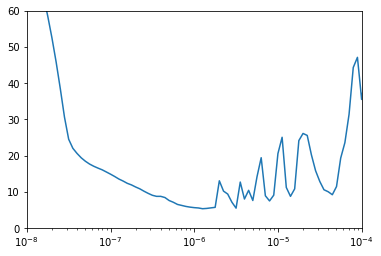

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train_coffee, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size_coffee)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 4s 62ms/step - loss: 19.9843 - mae: 20.4790
Epoch 2/150
25/25 [==============================] - 2s 63ms/step - loss: 10.0935 - mae: 10.5828
Epoch 3/150
25/25 [==============================] - 2s 63ms/step - loss: 7.5530 - mae: 8.0393
Epoch 4/150
25/25 [==============================] - 2s 67ms/step - loss: 5.5785 - mae: 6.0572
Epoch 5/150
25/25 [==============================] - 2s 69ms/step - loss: 9.8973 - mae: 10.3885
Epoch 6/150
25/25 [==============================] - 2s 65ms/step - loss: 6.6138 - mae: 7.0957
Epoch 7/150
25/25 [==============================] - 2s 69ms/step - loss: 7.8637 - mae: 8.3463
Epoch 8/150
25/25 [==============================] - 2s 66ms/step - loss: 9.6615 - mae: 10.1513
Epoch 9/150
25/25 [==============================] - 2s 67ms/step - loss: 5.6515 - mae: 6.1309
Epoch 10/150
25/25 [==============================] - 2s 68ms/step - loss: 5.6920 - mae: 6.1728
Epoch 11/150
25/25 [=======================

25/25 [==============================] - 2s 68ms/step - loss: 1.8593 - mae: 2.3104
Epoch 87/150
25/25 [==============================] - 2s 69ms/step - loss: 1.7108 - mae: 2.1570
Epoch 88/150
25/25 [==============================] - 2s 67ms/step - loss: 2.1073 - mae: 2.5626
Epoch 89/150
25/25 [==============================] - 2s 70ms/step - loss: 2.2335 - mae: 2.6908
Epoch 90/150
25/25 [==============================] - 2s 69ms/step - loss: 2.3067 - mae: 2.7674
Epoch 91/150
25/25 [==============================] - 2s 65ms/step - loss: 1.7788 - mae: 2.2270
Epoch 92/150
25/25 [==============================] - 2s 67ms/step - loss: 1.7731 - mae: 2.2187
Epoch 93/150
25/25 [==============================] - 2s 70ms/step - loss: 1.8103 - mae: 2.2582
Epoch 94/150
25/25 [==============================] - 2s 69ms/step - loss: 1.9021 - mae: 2.3547
Epoch 95/150
25/25 [==============================] - 2s 75ms/step - loss: 1.8137 - mae: 2.2640
Epoch 96/150
25/25 [==============================] -

In [10]:
rnn_forecast = model_forecast(model, coffee_series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time_coffee - window_size:-1, -1, 0]

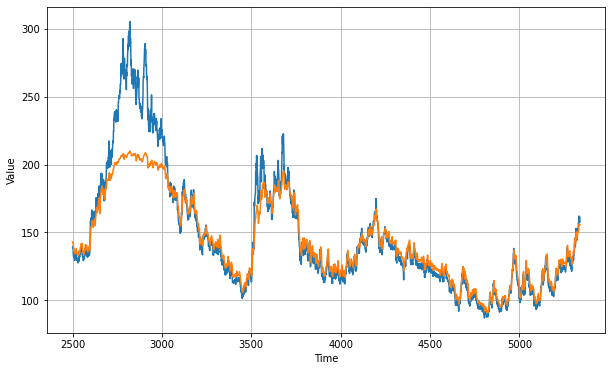

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid_coffee, x_valid_coffee)
plot_series(time_valid_coffee, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid_coffee, rnn_forecast).numpy()

8.807057

In [13]:
days_future = 180*2
temp = len(x_valid_coffee)-days_future
temp = x_valid_coffee[temp:]

mantap_mania = []

for i in range(days_future):
    rnn_forecast = model_forecast(model, temp[..., np.newaxis], len(temp))
    waw = rnn_forecast[0][-1][0]
    mantap_mania.append(waw)
    
    temp = np.delete(temp, 0)
    temp = np.append(temp, waw)

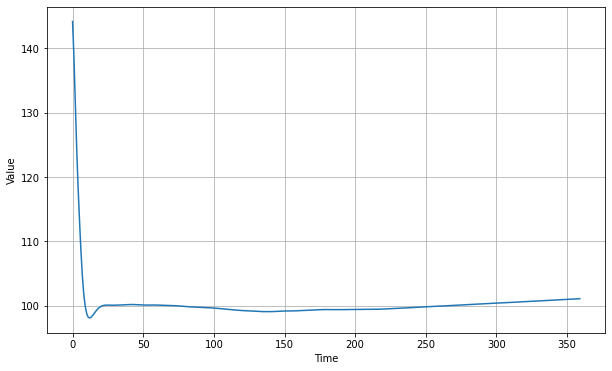

In [14]:
plt.figure(figsize=(10, 6))
coffee_range_zero = range(len(mantap_mania))
plot_series(coffee_range_zero, mantap_mania)

In [15]:
print(mantap_mania)

[144.19484, 138.45793, 131.19362, 123.88234, 117.98825, 112.845276, 108.24456, 104.40303, 101.633286, 99.85097, 98.76168, 98.23532, 98.0879, 98.18618, 98.41849, 98.711754, 99.01142, 99.28615, 99.53387, 99.727776, 99.87555, 99.98262, 100.04302, 100.07582, 100.089355, 100.09035, 100.083244, 100.07784, 100.07472, 100.07217, 100.07564, 100.08818, 100.08905, 100.09958, 100.10402, 100.11249, 100.12364, 100.12907, 100.14683, 100.15479, 100.17039, 100.184265, 100.1816, 100.1812, 100.16829, 100.15609, 100.154686, 100.147415, 100.1323, 100.12453, 100.1122, 100.09931, 100.09397, 100.09587, 100.09173, 100.09892, 100.10094, 100.10538, 100.105835, 100.10293, 100.08971, 100.08473, 100.07558, 100.063705, 100.05832, 100.04611, 100.03944, 100.03456, 100.02859, 100.02053, 100.01719, 100.00687, 100.00193, 99.990616, 99.97784, 99.96461, 99.94553, 99.93166, 99.911736, 99.89045, 99.87068, 99.85015, 99.832214, 99.8187, 99.80322, 99.79581, 99.78609, 99.77614, 99.7681, 99.75715, 99.74802, 99.73376, 99.72465, 99

In [16]:
model.save('coffee_model.h5')